In [4]:
# Importing the necessary Packages.
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,mean_absolute_error
from sklearn.naive_bayes import GaussianNB
from scipy.ndimage import interpolation as inter
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
from future.utils import iteritems
import scipy.optimize as op 
import seaborn as sn

In [5]:
# Reading the dataset using Tensor Flow and keras.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Reshaping each image as one array of 784 pixels or we can call as 1-D vectors,for both train and test.
x_train=np.reshape(x_train,(60000,784))
x_test=np.reshape(x_test,(10000,784))

In [6]:
# generate the random indices using numpy for both train and test, 1000 training indices and 500 testing indices are obtained. 
indices_1=np.random.choice(x_train.shape[0],60000,replace=False)
indices_t1=np.random.choice(x_test.shape[0],10000,replace=False)
# Obtaining the rows from the obtained respective indices of training and test.
x_1=x_train[indices_1]
y_1=y_train[indices_1]
x_t1=x_test[indices_t1]
y_t1=y_test[indices_t1]
# Adding ones to to both train and test set x
x_1=np.column_stack([np.ones([x_1.shape[0], 1], dtype=np.int32),x_1])
x_t1=np.column_stack([np.ones([x_t1.shape[0], 1], dtype=np.int32),x_t1])

#### Creating a Naive Bayes Classifier

1. The function takes training features, labels and Test features as input parameters.

2. Functions calculates the mean and covariance for each label and stores it in a dictionary.

3. The Prior probabilities is obtained by taking the number of times class occured divided by sample length.

4. Using these means and covariances, calculate probability that the test input belongs to a given class.

5. From the list of probabilities for each class we pick the maximum probability to decide which class the input belongs to.

6. Plot images for mean and variances. 

7. Return a list of prediction values for further calculations.


In [7]:
def NaiveBayes(X_train, y_train, X_test):
  gaussians = dict()
  prior_probabs= dict()
  label_train = set(y_train)
  #label_test = set(y_test)
  for c in label_train:
    current_X = X_train[y_train==c]
    gaussians[c] = {
        'mean':current_X.mean(axis=0), # Mean for each digit.
        'cov' : current_X.var(axis=0)+1e-2 # Covariance for each digit with addition of a little noise to avoid singularity.
    }
    #prior probability is the number of times class occured divided by the sample length
    prior_probabs[c] = float(len([y_train==c]))/len(y_train)
    N, D = X_test.shape
    Probabilties = np.zeros((N, len(gaussians))) # Array of zeros to store probability for each class.
    # Calculating the probabilities.
    for c, g in iteritems(gaussians):
      mean, cov = g['mean'], g['cov']
      Probabilties[:,c] = mvn.logpdf(X_test, mean=mean, cov=cov) + np.log(prior_probabs[c])
    Prediction = np.argmax(Probabilties, axis=1)
  
  print('-------Mean for each class-------')
  for c,g in iteritems(gaussians):
    plt.imshow(g['mean'].reshape(28, 28))
    plt.title(c)
    plt.show()

  print('-------Covariance for each class-------')
  for c,g in iteritems(gaussians):
    plt.imshow(g['cov'].reshape(28, 28))
    plt.title(c)
    plt.show()

  return Prediction

-------Mean for each class-------


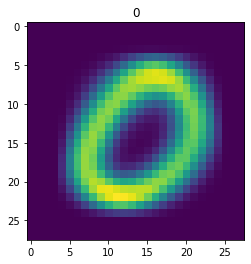

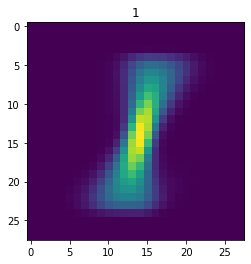

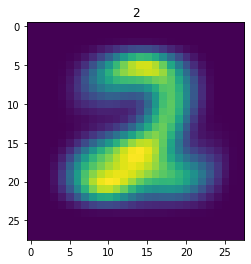

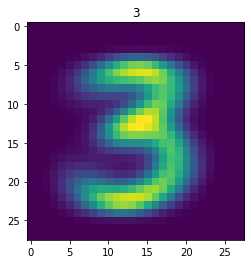

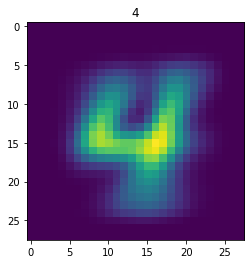

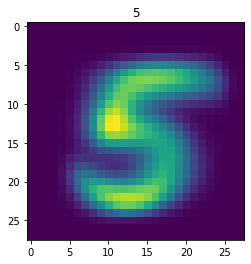

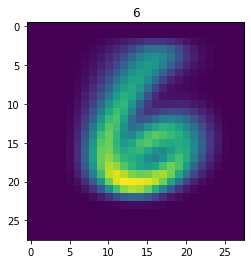

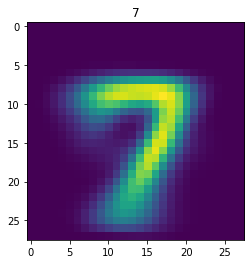

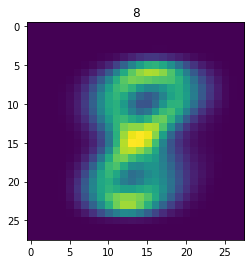

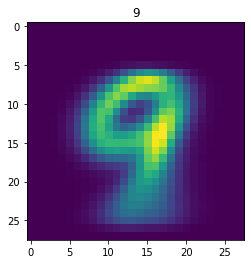

-------Covariance for each class-------


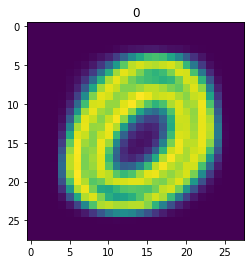

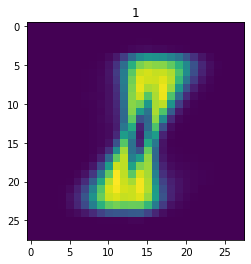

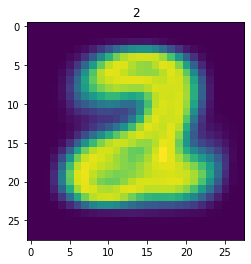

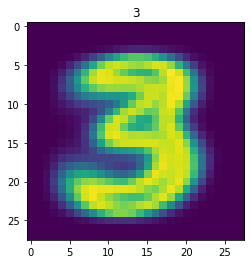

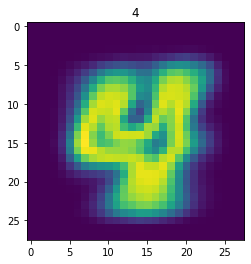

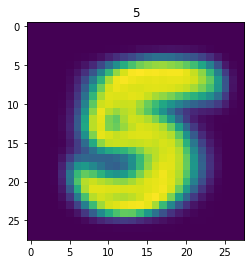

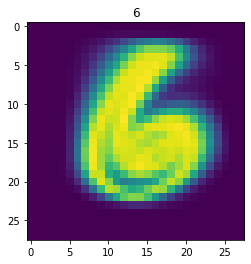

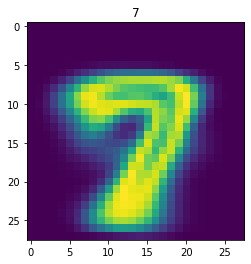

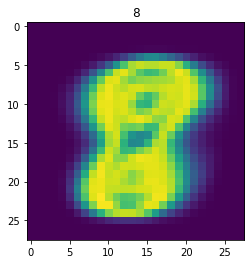

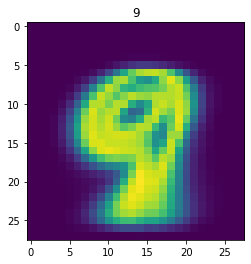

In [8]:
# Calling the Naive bayes classifier function.
pred = NaiveBayes(x_train,y_train,x_test)

In [9]:
# Calculating the overall accuracy of the Classifier.
score = np.mean(pred==y_test)
print('The Accuray of Naive-Bayes classifier is : %f' %(score*100),'%' )

The Accuray of Naive-Bayes classifier is : 61.290000 %


In [10]:
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix 
unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()
cm1 = confusion_matrix(y_test,pred)
a=cm1.diagonal()
acc = accuracy_score(y_test,pred)
print("The confusion Matrix is given by: \n",cm1)
print('\nAccuracy of Classifier on Test Images: ',acc)
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['accuracy']
acc

The confusion Matrix is given by: 
 [[ 880    1    3    6    3    8   29    1   32   17]
 [   0 1089    2    2    0    1    9    0   30    2]
 [  51   30  395   86    6    2  218    6  223   15]
 [  23   43    8  521    3    3   39    9  274   87]
 [  15    6    7    4  285    9   53    9  140  454]
 [  72   28    3   28    9   90   37    3  536   86]
 [  13   13    5    1    1    7  891    0   26    1]
 [   0   16    2   13    7    2    4  360   36  588]
 [  12   85    4   10    5   17   11    6  676  148]
 [   5   12    3    8    5    0    1   15   18  942]]

Accuracy of Classifier on Test Images:  0.6129


,accuracy
digit 0,89.795918
digit 1,95.947137
digit 2,38.275194
digit 3,51.584158
digit 4,29.022403
digit 5,10.089686
digit 6,93.006263
digit 7,35.019455
digit 8,69.404517
digit 9,93.359762


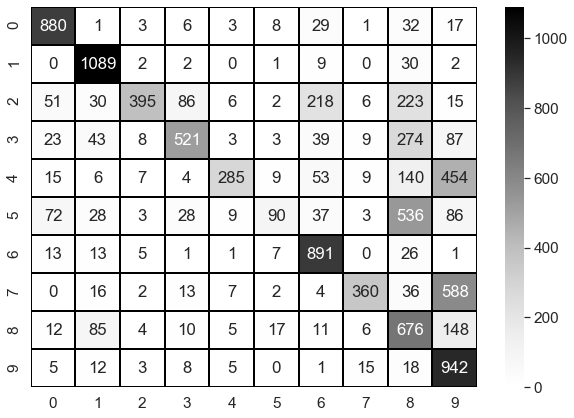

In [11]:
sn.set(font_scale=1.4) # for label size
plt.figure(figsize = (10,7))
cm_heat1=sn.heatmap(cm1, annot=True,cmap='Greys',linecolor='black',fmt='d',linewidths=1)

#### Logistic Regression Classifer

1. The first step in the logistic regression classifier is to find the optimised using the gradient decent using TNC method, iteratively optimise the values of weight.

2. We combine all the positive examples for given class and rest are assigned to another class. For our problem we have created 10 such classifier, where each classifier takes one digit as positive and rest as negative.

3. Tabulating the accuracy for each Lambda - Regularized value.

In [ ]:
#Logistic Regression

def sigmoid(z):
    sig=1.0 / (1 + np.exp(-z))
    return sig

#Regularized cost function
def cost_fun(angle, X, y, _lambda = 0.1):
    m = len(y)
    h = sigmoid(X.dot(angle))
    reg = (_lambda/(2 * m)) * np.sum(angle**2)
    ct_fn= (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg
    return ct_fn

#Regularized gradient function
def gradient(angle, X, y, _lambda = 0.1):
    m, n = X.shape
    angle = angle.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(angle))
    reg = _lambda * angle /m
    grad=((1 / m) * X.T.dot(h - y)) + reg
    return grad

#Optimal angle 
def logisticRegression(X, y, angle,_lambda=0.1):
    result = op.minimize(fun = cost_fun, x0 = angle, args = (X, y,_lambda),
                         method = 'TNC', jac = gradient)
    
    return result.x

#Training

k=10
n=784

#One vs all

ord=np.unique(y_t1)
lambda_=[.001,.01,0.1,1,10,100]
#lambda_=[0.1,1]
inter_array={}
final_predictions=[]
final_accuracy=[]
for lamba in (lambda_):
    i = 0
    all_angle = np.zeros((k, n+1))
    for dig in (ord):
    #set the labels in 0 and 1
        tmp_y = np.array(y_1 == dig, dtype = int)
        optangle = logisticRegression(x_1, tmp_y, np.zeros((n + 1,1)),lamba)
        all_angle[i] = optangle
        i += 1
    inter_array[lamba]=all_angle
  #Predictions
    P = sigmoid(x_t1.dot(all_angle.T)) #probability for each dig
    p = [ord[np.argmax(P[i, :])] for i in range(x_t1.shape[0])]
    final_predictions.append(p)
    final_accuracy.append(accuracy_score(y_t1, p) * 100)
    print("Test Accuracy ", accuracy_score(y_t1, p) * 100 , '%')
acc={'Accuracy in %':final_accuracy,'Lambda':lambda_}
accuracy_frame=pd.DataFrame(acc)
accuracy_frame

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Test Accuracy  91.63 %
Test Accuracy  91.66 %
Test Accuracy  91.63 %
Test Accuracy  91.71000000000001 %
Test Accuracy  91.74 %


In [ ]:
# Plotting a graph Accuracy vs Log Lambda.
Accuracy=final_accuracy
lamda_=[0.001,0.01,0.1,1,10,100]
plt.title('Change in accuracy with regularization')
plt.xlabel('Log of Regularizer  value (Lambda)')
plt.ylabel('Test Accuracy')
plt.plot(np.log(lamda_),Accuracy)

In [ ]:
# Printing the Confusion Matrix
ind=final_accuracy.index(max(final_accuracy))
Predtion=final_predictions[ind]
cm2 = confusion_matrix(y_t1,Predtion)
sn.set(font_scale=1.4) # for label size
plt.figure(figsize = (10,7))
cm_heat2=sn.heatmap(cm, annot=True,cmap='Greys',linecolor='black',fmt='d',linewidths=1)

In [ ]:
# Printing the accuracy in each digit.
a=cm2.diagonal()
accuracy={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique, counts = np.unique(y_t1, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((1-(a[i]/counts[i]))*100)
    accuracy[i]=e
column=[]
for i in range(0,10):
    column.append('Accuracy for  digit '+str(i))    
accuracy=pd.DataFrame(accuracy)
accuracy.columns=column
accuracy=accuracy.T
accuracy.columns=['Accuracy in detecting each digit']
accuracy

In [ ]:
# Displaying a graph to provide the error in each digit prediction.
Digit=[0,1,2,3,4,5,6,7,8,9]
error={}
for i in range(0,len(a)):
    e=[]
    e.append(((a[i]/counts[i]))*100)
    error[i]=e
column=[]
for i in range(0,10):
    column.append('Accuracy for  digit '+str(i))    
error=pd.DataFrame(error)
error.columns=column
error=error.T
error.columns=['Error in detecting each digit']
error
error_in_digit=error['Error in detecting each digit']
plt.xlabel('Digit')
plt.ylabel('Error in %')
plt.xticks(Digit)
plt.title('Error in predicting each digit')
plt.bar(Digit,error_in_digit)

In [ ]:
# Displaying the images after one vs all 
arr=inter_array[list(inter_array.keys())[ind]]
fig, axs = plt.subplots(5,2, figsize=(10, 20))
plt.tight_layout()
in_1=[0,1,2,3,4,5,6,7,8,9]
for ax,digit,i in zip(axs.flatten(),arr,in_1):
    ax.set(title='784 weights for digit '+str(i))
    ax.imshow(digit[1:].reshape(28,28),interpolation='gaussian',cmap=plt.cm.Blues)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
arr1=scaler.fit(arr).transform(arr)
fig, axs = plt.subplots(5,2, figsize=(10, 20))
plt.tight_layout()
in_1=[0,1,2,3,4,5,6,7,8,9]
for ax,digit,i in zip(axs.flatten(),arr1,in_1):
    ax.set(title='784 weights for digit '+str(i))
    ax.imshow(digit[1:].reshape(28,28),interpolation='gaussian',cmap=plt.cm.Blues)